# 现代机器学习II(2024春)结课设计

## 结课设计要求

> 根据课程对生成模型的学习，在课程提供的代码的基础上修改代码，比较四种生成模型。
> 1. 用pytorch lightning 实现四种生成模型的对比；
> 2. 如果使用了notebook，并在notebook中详细说明了比较结果和结论，可不单独提供实验报告，否则请按目标提交报告。
> 3. 使用课堂发布的数据集，提交的代码不要包含数据集和生成的结果。


## 本notebook文件的目录

1. 课程设计简介(本部分)
2. 导入所需库文件
3. 定义数据集类
4. 各生成模型的实现与结果展示
    1. NF
    2. GAN
    3. VAE
    4. Diffussion
5. 结果对比与实验结论

## 实验Setting

1. 由于不同生成模型的train loss不具有泛化的参考意义，故本次试验仅展示定性结果Qualitative Results，即渲染结果。
2. 如需 evaluate 定量结果，**可以从[此链接]()下载预训练模型，并解压到当前目录下**，加载pretrained model进行测试。
3. 本次试验的硬件设施参考以下信息：
    > Global seed set to 42   
    > python version: 3.9.18 (main, Sep 11 2023, 13:41:44)    
    > [GCC 11.2.0]   
    > torch version: 2.0.1+cu117   
    > cuda available: True   
4. 本次试验使用MNIST数据集。
5. 除diffusion外，每个生成模型均训练200 epochs，diffusion训练54个epoch。

本阶段导入了一系列训练过程中需要使用到的标准库与深度学习库，用于训练，初始化，数据处理，结果可视化等。

In [2]:
# Standard libraries
import os
import json
import math
import random
import sys
import time
import argparse

# Numpy
import numpy as np 

# Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset, random_split

# ProgressBar
from tqdm.notebook import tqdm

# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

import imageio

from IPython.display import Image

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "/data22/DISCOVER_summer2023/chenjt2305/dl/2023-2024-2/_assignments/final/datasets"
CHECKPOINT_PATH = "./final_checkpoints"
BATCH_SIZE = 256 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Print CUDA and torch version information
print(f"python version: {sys.version}")
print(f"torch version: {torch.__version__}")
print(f"cuda available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/tmp/ipykernel_3812761/2123319960.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Global seed set to 42


python version: 3.9.18 (main, Sep 11 2023, 13:41:44) 
[GCC 11.2.0]
torch version: 2.0.1+cu117
cuda available: True


本阶段初始化了一系列数据集类，其中定义`MNISTDataModule`作为可泛化的数据集类，对于diffusion model，我们采用了不同的数据处理方式，故定义`DiffSet`。

In [3]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(
        self,
        data_dir: str = DATASET_PATH,
        batch_size: int = BATCH_SIZE,
        num_workers: int = NUM_WORKERS,
    ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        self.dims = (1, 28, 28)
        self.num_classes = 10

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(
                self.data_dir, train=False, transform=self.transform
            )

    def train_dataloader(self):
        return DataLoader(
            self.mnist_train,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers
        )

    def test_dataloader(self):
        return DataLoader(
            self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers
        )

dm = MNISTDataModule()

In [4]:
# Process datasets


# 0-1 to 0-255
def discretize(x):
    return (x * 255).type(torch.int32)


# Transformations applied to the data
transform = transforms.Compose([transforms.ToTensor(), discretize])

# Load the training and test datasets
train_dataset = MNIST(DATASET_PATH, train=True, download=False, transform=transform)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])
test_set = MNIST(DATASET_PATH, train=False, download=True, transform=transform)

# Data loaders
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=256,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=8,
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4
)

In [5]:
class DiffSet(Dataset):
    def __init__(self, train, dataset="MNIST"):
        transform = transforms.Compose([transforms.ToTensor()])

        datasets = {
            "MNIST": MNIST,
        }

        train_dataset = MNIST(DATASET_PATH, train=train, transform=transform)

        self.dataset_len = len(train_dataset.data)

        pad = transforms.Pad(2)
        data = pad(train_dataset.data)
        data = data.unsqueeze(3)
        self.depth = 1
        self.size = 32

        self.input_seq = ((data / 255.0) * 2.0) - 1.0
        self.input_seq = self.input_seq.moveaxis(3, 1)

    def __len__(self):
        return self.dataset_len

    def __getitem__(self, item):
        return self.input_seq[item]



# NF

在下面的代码块中，我们基于torch与pytorch lightning实现了自定义的归一化流类，并定义了一系列用于训练的utils函数。本次实验中我们采用的是multiscale的归一化流模型。

In [6]:
class ImageFlow(pl.LightningModule):

    def __init__(self, flows, import_samples=8):
        """
        Inputs:
            flows - A list of flows (each a nn.Module) that should be applied on the images.
            import_samples - Number of importance samples to use during testing (see explanation below). Can be changed at any time
        """
        super().__init__()
        self.flows = nn.ModuleList(flows)
        self.import_samples = import_samples
        # Create prior distribution for final latent space
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
        # Example input for visualizing the graph
        self.example_input_array = train_set[0][0].unsqueeze(dim=0)

    def forward(self, imgs):
        # The forward function is only used for visualizing the graph
        return self._get_likelihood(imgs)

    def encode(self, imgs):
        # Given a batch of images, return the latent representation z and ldj of the transformations
        z, ldj = imgs, torch.zeros(imgs.shape[0], device=self.device)
        for flow in self.flows:
            z, ldj = flow(z, ldj, reverse=False)
        return z, ldj

    def _get_likelihood(self, imgs, return_ll=False):
        """
        Given a batch of images, return the likelihood of those.
        If return_ll is True, this function returns the log likelihood of the input.
        Otherwise, the ouptut metric is bits per dimension (scaled negative log likelihood)
        """
        z, ldj = self.encode(imgs)
        log_pz = self.prior.log_prob(z).sum(dim=[1, 2, 3])
        log_px = ldj + log_pz
        nll = -log_px
        # Calculating bits per dimension
        bpd = nll * np.log2(np.exp(1)) / np.prod(imgs.shape[1:])
        return bpd.mean() if not return_ll else log_px

    @torch.no_grad()
    def sample(self, img_shape, z_init=None):
        """
        Sample a batch of images from the flow.
        """
        # Sample latent representation from prior
        if z_init is None:
            z = self.prior.sample(sample_shape=img_shape).to(device)
        else:
            z = z_init.to(device)

        # Transform z to x by inverting the flows
        ldj = torch.zeros(img_shape[0], device=device)
        for flow in reversed(self.flows):
            z, ldj = flow(z, ldj, reverse=True)
        return z

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # An scheduler is optional, but can help in flows to get the last bpd improvement
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # Normalizing flows are trained by maximum likelihood => return bpd
        loss = self._get_likelihood(batch[0])
        self.log("train_bpd", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_likelihood(batch[0])
        self.log("val_bpd", loss)

    def test_step(self, batch, batch_idx):
        # Perform importance sampling during testing => estimate likelihood M times for each image
        samples = []
        for _ in range(self.import_samples):
            img_ll = self._get_likelihood(batch[0], return_ll=True)
            samples.append(img_ll)
        img_ll = torch.stack(samples, dim=-1)

        # To average the probabilities, we need to go from log-space to exp, and back to log.
        # Logsumexp provides us a stable implementation for this
        img_ll = torch.logsumexp(img_ll, dim=-1) - np.log(self.import_samples)

        # Calculate final bpd
        bpd = -img_ll * np.log2(np.exp(1)) / np.prod(batch[0].shape[1:])
        bpd = bpd.mean()

        self.log("test_bpd", bpd)


class Dequantization(nn.Module):

    def __init__(self, alpha=1e-5, quants=256):
        """
        Inputs:
            alpha - small constant that is used to scale the original input.
                    Prevents dealing with values very close to 0 and 1 when inverting the sigmoid
            quants - Number of possible discrete values (usually 256 for 8-bit image)
        """
        super().__init__()
        self.alpha = alpha
        self.quants = quants

    def forward(self, z, ldj, reverse=False):
        if not reverse:
            z, ldj = self.dequant(z, ldj)
            z, ldj = self.sigmoid(z, ldj, reverse=True)
        else:
            z, ldj = self.sigmoid(z, ldj, reverse=False)
            z = z * self.quants
            ldj += np.log(self.quants) * np.prod(z.shape[1:])
            z = torch.floor(z).clamp(min=0, max=self.quants - 1).to(torch.int32)
        return z, ldj

    def sigmoid(self, z, ldj, reverse=False):
        # Applies an invertible sigmoid transformation
        if not reverse:
            ldj += (-z - 2 * F.softplus(-z)).sum(dim=[1, 2, 3])
            z = torch.sigmoid(z)
            # Reversing scaling for numerical stability
            ldj -= np.log(1 - self.alpha) * np.prod(z.shape[1:])
            z = (z - 0.5 * self.alpha) / (1 - self.alpha)
        else:
            z = (
                z * (1 - self.alpha) + 0.5 * self.alpha
            )  # Scale to prevent boundaries 0 and 1
            ldj += np.log(1 - self.alpha) * np.prod(z.shape[1:])
            ldj += (-torch.log(z) - torch.log(1 - z)).sum(dim=[1, 2, 3])
            z = torch.log(z) - torch.log(1 - z)
        return z, ldj

    def dequant(self, z, ldj):
        # Transform discrete values to continuous volumes
        z = z.to(torch.float32)
        z = z + torch.rand_like(z).detach()
        z = z / self.quants
        ldj -= np.log(self.quants) * np.prod(z.shape[1:])
        return z, ldj


class VariationalDequantization(Dequantization):

    def __init__(self, var_flows, alpha=1e-5):
        """
        Inputs:
            var_flows - A list of flow transformations to use for modeling q(u|x)
            alpha - Small constant, see Dequantization for details
        """
        super().__init__(alpha=alpha)
        self.flows = nn.ModuleList(var_flows)

    def dequant(self, z, ldj):
        z = z.to(torch.float32)
        img = (
            z / 255.0
        ) * 2 - 1  # We condition the flows on x, i.e. the original image

        # Prior of u is a uniform distribution as before
        # As most flow transformations are defined on [-infinity,+infinity], we apply an inverse sigmoid first.
        deq_noise = torch.rand_like(z).detach()
        deq_noise, ldj = self.sigmoid(deq_noise, ldj, reverse=True)
        for flow in self.flows:
            deq_noise, ldj = flow(deq_noise, ldj, reverse=False, orig_img=img)
        deq_noise, ldj = self.sigmoid(deq_noise, ldj, reverse=False)

        # After the flows, apply u as in standard dequantization
        z = (z + deq_noise) / 256.0
        ldj -= np.log(256.0) * np.prod(z.shape[1:])
        return z, ldj


class CouplingLayer(nn.Module):

    def __init__(self, network, mask, c_in):
        """
        Coupling layer inside a normalizing flow.
        Inputs:
            network - A PyTorch nn.Module constituting the deep neural network for mu and sigma.
                      Output shape should be twice the channel size as the input.
            mask - Binary mask (0 or 1) where 0 denotes that the element should be transformed,
                   while 1 means the latent will be used as input to the NN.
            c_in - Number of input channels
        """
        super().__init__()
        self.network = network
        self.scaling_factor = nn.Parameter(torch.zeros(c_in))
        # Register mask as buffer as it is a tensor which is not a parameter,
        # but should be part of the modules state.
        self.register_buffer("mask", mask)

    def forward(self, z, ldj, reverse=False, orig_img=None):
        """
        Inputs:
            z - Latent input to the flow
            ldj - The current ldj of the previous flows.
                  The ldj of this layer will be added to this tensor.
            reverse - If True, we apply the inverse of the layer.
            orig_img (optional) - Only needed in VarDeq. Allows external
                                  input to condition the flow on (e.g. original image)
        """
        # Apply network to masked input
        z_in = z * self.mask
        if orig_img is None:
            nn_out = self.network(z_in)
        else:
            nn_out = self.network(torch.cat([z_in, orig_img], dim=1))
        s, t = nn_out.chunk(2, dim=1)

        # Stabilize scaling output
        s_fac = self.scaling_factor.exp().view(1, -1, 1, 1)
        s = torch.tanh(s / s_fac) * s_fac

        # Mask outputs (only transform the second part)
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)

        # Affine transformation
        if not reverse:
            # Whether we first shift and then scale, or the other way round,
            # is a design choice, and usually does not have a big impact
            z = (z + t) * torch.exp(s)
            ldj += s.sum(dim=[1, 2, 3])
        else:
            z = (z * torch.exp(-s)) - t
            ldj -= s.sum(dim=[1, 2, 3])

        return z, ldj


class ConcatELU(nn.Module):
    """
    Activation function that applies ELU in both direction (inverted and plain).
    Allows non-linearity while providing strong gradients for any input (important for final convolution)
    """

    def forward(self, x):
        return torch.cat([F.elu(x), F.elu(-x)], dim=1)


class LayerNormChannels(nn.Module):

    def __init__(self, c_in, eps=1e-5):
        """
        This module applies layer norm across channels in an image.
        Inputs:
            c_in - Number of channels of the input
            eps - Small constant to stabilize std
        """
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(1, c_in, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, c_in, 1, 1))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        var = x.var(dim=1, unbiased=False, keepdim=True)
        y = (x - mean) / torch.sqrt(var + self.eps)
        y = y * self.gamma + self.beta
        return y


class GatedConv(nn.Module):

    def __init__(self, c_in, c_hidden):
        """
        This module applies a two-layer convolutional ResNet block with input gate
        Inputs:
            c_in - Number of channels of the input
            c_hidden - Number of hidden dimensions we want to model (usually similar to c_in)
        """
        super().__init__()
        self.net = nn.Sequential(
            ConcatELU(),
            nn.Conv2d(2 * c_in, c_hidden, kernel_size=3, padding=1),
            ConcatELU(),
            nn.Conv2d(2 * c_hidden, 2 * c_in, kernel_size=1),
        )

    def forward(self, x):
        out = self.net(x)
        val, gate = out.chunk(2, dim=1)
        return x + val * torch.sigmoid(gate)


class GatedConvNet(nn.Module):

    def __init__(self, c_in, c_hidden=32, c_out=-1, num_layers=3):
        """
        Module that summarizes the previous blocks to a full convolutional neural network.
        Inputs:
            c_in - Number of input channels
            c_hidden - Number of hidden dimensions to use within the network
            c_out - Number of output channels. If -1, 2 times the input channels are used (affine coupling)
            num_layers - Number of gated ResNet blocks to apply
        """
        super().__init__()
        c_out = c_out if c_out > 0 else 2 * c_in
        layers = []
        layers += [nn.Conv2d(c_in, c_hidden, kernel_size=3, padding=1)]
        for layer_index in range(num_layers):
            layers += [GatedConv(c_hidden, c_hidden), LayerNormChannels(c_hidden)]
        layers += [
            ConcatELU(),
            nn.Conv2d(2 * c_hidden, c_out, kernel_size=3, padding=1),
        ]
        self.nn = nn.Sequential(*layers)

        self.nn[-1].weight.data.zero_()
        self.nn[-1].bias.data.zero_()

    def forward(self, x):
        return self.nn(x)


class SqueezeFlow(nn.Module):

    def forward(self, z, ldj, reverse=False):
        B, C, H, W = z.shape
        if not reverse:
            # Forward direction: H x W x C => H/2 x W/2 x 4C
            z = z.reshape(B, C, H // 2, 2, W // 2, 2)
            z = z.permute(0, 1, 3, 5, 2, 4)
            z = z.reshape(B, 4 * C, H // 2, W // 2)
        else:
            # Reverse direction: H/2 x W/2 x 4C => H x W x C
            z = z.reshape(B, C // 4, 2, 2, H, W)
            z = z.permute(0, 1, 4, 2, 5, 3)
            z = z.reshape(B, C // 4, H * 2, W * 2)
        return z, ldj


class SplitFlow(nn.Module):

    def __init__(self):
        super().__init__()
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)

    def forward(self, z, ldj, reverse=False):
        if not reverse:
            z, z_split = z.chunk(2, dim=1)
            ldj += self.prior.log_prob(z_split).sum(dim=[1, 2, 3])
        else:
            z_split = self.prior.sample(sample_shape=z.shape).to(device)
            z = torch.cat([z, z_split], dim=1)
            ldj -= self.prior.log_prob(z_split).sum(dim=[1, 2, 3])
        return z, ldj

# utils

def create_checkerboard_mask(h, w, invert=False):
    x, y = torch.arange(h, dtype=torch.int32), torch.arange(w, dtype=torch.int32)
    xx, yy = torch.meshgrid(x, y, indexing="ij")
    mask = torch.fmod(xx + yy, 2)
    mask = mask.to(torch.float32).view(1, 1, h, w)
    if invert:
        mask = 1 - mask
    return mask


def create_multiscale_flow():
    flow_layers = []

    vardeq_layers = [
        CouplingLayer(
            network=GatedConvNet(c_in=2, c_out=2, c_hidden=16),
            mask=create_checkerboard_mask(h=28, w=28, invert=(i % 2 == 1)),
            c_in=1,
        )
        for i in range(4)
    ]
    flow_layers += [VariationalDequantization(vardeq_layers)]

    flow_layers += [
        CouplingLayer(
            network=GatedConvNet(c_in=1, c_hidden=32),
            mask=create_checkerboard_mask(h=28, w=28, invert=(i % 2 == 1)),
            c_in=1,
        )
        for i in range(2)
    ]
    flow_layers += [SqueezeFlow()]
    for i in range(2):
        flow_layers += [
            CouplingLayer(
                network=GatedConvNet(c_in=4, c_hidden=48),
                mask=create_channel_mask(c_in=4, invert=(i % 2 == 1)),
                c_in=4,
            )
        ]
    flow_layers += [SplitFlow(), SqueezeFlow()]
    for i in range(4):
        flow_layers += [
            CouplingLayer(
                network=GatedConvNet(c_in=8, c_hidden=64),
                mask=create_channel_mask(c_in=8, invert=(i % 2 == 1)),
                c_in=8,
            )
        ]

    flow_model = ImageFlow(flow_layers).to(device)
    return flow_model


def create_channel_mask(c_in, invert=False):
    mask = torch.cat(
        [
            torch.ones(c_in // 2, dtype=torch.float32),
            torch.zeros(c_in - c_in // 2, dtype=torch.float32),
        ]
    )
    mask = mask.view(1, c_in, 1, 1)
    if invert:
        mask = 1 - mask
    return mask


def train_flow(flow, model_name="MNISTFlow", pretrained_filename=None):
    # Create a PyTorch Lightning trainer
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, model_name),
        accelerator="auto",
        devices=[6],
        max_epochs=200,
        gradient_clip_val=1.0,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_bpd"),
            LearningRateMonitor("epoch"),
        ],
        check_val_every_n_epoch=5,
    )
    trainer.logger._log_graph = True
    trainer.logger._default_hp_metric = (
        None  # Optional logging argument that we don't need
    )

    result = None

    # Check whether pretrained model exists. If yes, load it and skip training

    if pretrained_filename is None:
        pretrained_filename = os.path.join(CHECKPOINT_PATH, model_name + ".ckpt")
    
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        ckpt = torch.load(pretrained_filename)
        flow.load_state_dict(ckpt["state_dict"])
        result = ckpt.get("result", None)
    else:
        print("Start training", model_name)
        trainer.fit(flow, train_loader, val_loader)

    # Test best model on validation and test set if no result has been found
    # Testing can be expensive due to the importance sampling.
    if result is None:
        val_result = trainer.test(flow, val_loader, verbose=False)
        start_time = time.time()
        test_result = trainer.test(flow, test_loader, verbose=False)
        duration = time.time() - start_time
        result = {
            "test": test_result,
            "val": val_result,
            "time": duration / len(test_loader) / flow.import_samples,
        }

    return flow, result


def show_imgs(imgs, title=None, row_size=4):
    # Form a grid of pictures (we use max. 8 columns)
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    is_int = (
        imgs.dtype == torch.int32
        if isinstance(imgs, torch.Tensor)
        else imgs[0].dtype == torch.int32
    )
    nrow = min(num_imgs, row_size)
    ncol = int(math.ceil(num_imgs / nrow))
    imgs = torchvision.utils.make_grid(
        imgs, nrow=nrow, pad_value=128 if is_int else 0.5
    )
    np_imgs = imgs.cpu().numpy()
    # Plot the grid
    plt.figure(figsize=(1.5 * nrow, 1.5 * ncol))
    plt.imshow(np.transpose(np_imgs, (1, 2, 0)), interpolation="nearest")
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()

在下面的代码中，我们对multiscale的normalized flow进行训练，训练200个epoch，并可视化训练结果。

In [7]:
# train the model

flow_dict = {"multiscale": {}}
flow_dict["multiscale"]["model"], flow_dict["multiscale"]["result"] = train_flow(
    create_multiscale_flow(),
    model_name="MNISTFlow_multiscale",
)

/data22/DISCOVER_summer2023/chenjt2305/.miniconda/envs/dl2023/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data22/DISCOVER_summer2023/chenjt2305/.miniconda/en ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data22/DISCOVER_summer2023/chenjt2305/.miniconda/envs/dl2023/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data22/DISCOVER_summer2023/chenjt2305/.miniconda/en ...
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize 

Start training MNISTFlow_multiscale



  | Name  | Type       | Params | In sizes | Out sizes
------------------------------------------------------------
0 | flows | ModuleList | 1.7 M  | ?        | ?        
------------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.847     Total estimated model params size (MB)
/data22/DISCOVER_summer2023/chenjt2305/.miniconda/envs/dl2023/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/data22/DISCOVER_summer2023/chenjt2305/.miniconda/envs/dl2023/lib/python3.9/site-packages/torch/jit/_trace.py:1084: TracerWarning: Output nr 1. of the traced function does not match the corresp

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/data22/DISCOVER_summer2023/chenjt2305/.miniconda/envs/dl2023/lib/python3.9/site-packages/torch/jit/_trace.py:1084: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Scalars are not close!

Absolute difference: 0.012418985366821289 (up to 1e-05 allowed)
Relative difference: 0.010276581275429306 (up to 1e-05 allowed)
  _check_trace(


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/data22/DISCOVER_summer2023/chenjt2305/.miniconda/envs/dl2023/lib/python3.9/site-packages/torch/jit/_trace.py:1084: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Scalars are not close!

Absolute difference: 0.017322897911071777 (up to 1e-05 allowed)
Relative difference: 0.0144490177819915 (up to 1e-05 allowed)
  _check_trace(


Testing: |          | 0/? [00:00<?, ?it/s]

以下代码用于可视化训练结果，我们随机sample了十六个生成的数字，并展示渲染结果。

Found pretrained model, loading...


Global seed set to 42


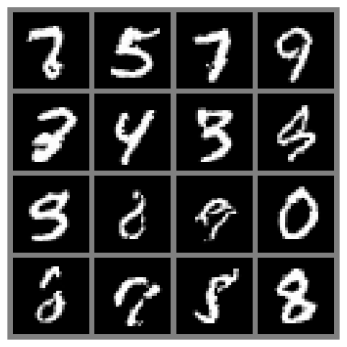

In [8]:
# visualize the results

flow = create_multiscale_flow()
print("Found pretrained model, loading...")
ckpt = torch.load(
    os.path.join(CHECKPOINT_PATH, "MNISTFlow_multiscale/lightning_logs/version_2/checkpoints/epoch=199-step=39000.ckpt")
)
flow.load_state_dict(ckpt["state_dict"])
result = ckpt.get("result", None)

pl.seed_everything(42)
samples = flow.sample(img_shape=[16, 8, 7, 7])
show_imgs(samples)

# GAN

以下代码为自定义实现的GAN网络模型，其中包括自定义的Generator与Discriminator。

In [9]:
class Generator(nn.Module):
    """
    >>> Generator(img_shape=(1, 8, 8))  # doctest: +ELLIPSIS +NORMALIZE_WHITESPACE
    Generator(
      (model): Sequential(...)
    )
    """

    def __init__(self, latent_dim: int = 100, img_shape: tuple = (1, 28, 28)):
        super().__init__()
        self.img_shape = img_shape

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(math.prod(img_shape))),
            nn.Tanh(),
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(img.size(0), *self.img_shape)


class Discriminator(nn.Module):
    """
    >>> Discriminator(img_shape=(1, 28, 28))  # doctest: +ELLIPSIS +NORMALIZE_WHITESPACE
    Discriminator(
      (model): Sequential(...)
    )
    """

    def __init__(self, img_shape):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(int(math.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)


class GAN(pl.LightningModule):
    def __init__(
        self,
        channels,
        width,
        height,
        latent_dim: int = 100,
        lr: float = 0.0002,
        b1: float = 0.5,
        b2: float = 0.999,
        batch_size: int = BATCH_SIZE,
        **kwargs,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False

        img_shape = (channels, width, height)

        # networks
        self.generator = Generator(latent_dim=self.hparams.latent_dim, img_shape=img_shape)
        self.discriminator = Discriminator(img_shape=img_shape)

        self.validation_z = torch.randn(8, self.hparams.latent_dim)

        self.example_input_array = torch.zeros(2, self.hparams.latent_dim)

    def forward(self, z):
        return self.generator(z)

    @staticmethod
    def adversarial_loss(y_hat, y):
        return F.binary_cross_entropy_with_logits(y_hat, y)

    def training_step(self, batch):
        imgs, _ = batch

        opt_g, opt_d = self.optimizers()

        # sample noise
        z = torch.randn(imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(imgs)

        # Train generator
        # ground truth result (ie: all fake)
        # put on GPU because we created this tensor inside training_loop
        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)

        self.toggle_optimizer(opt_g)
        # adversarial loss is binary cross-entropy
        g_loss = self.adversarial_loss(self.discriminator(self(z)), valid)
        opt_g.zero_grad()
        self.manual_backward(g_loss)
        opt_g.step()
        self.untoggle_optimizer(opt_g)

        # Train discriminator
        # Measure discriminator's ability to classify real from generated samples
        # how well can it label as real?
        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)

        self.toggle_optimizer(opt_d)
        real_loss = self.adversarial_loss(self.discriminator(imgs), valid)

        # how well can it label as fake?
        fake = torch.zeros(imgs.size(0), 1)
        fake = fake.type_as(imgs)

        fake_loss = self.adversarial_loss(self.discriminator(self(z).detach()), fake)

        # discriminator loss is the average of these
        d_loss = (real_loss + fake_loss) / 2

        opt_d.zero_grad()
        self.manual_backward(d_loss)
        opt_d.step()
        self.untoggle_optimizer(opt_d)

        self.log_dict({"d_loss": d_loss, "g_loss": g_loss})

    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return opt_g, opt_d

    def on_train_epoch_end(self):
        z = self.validation_z.type_as(self.generator.model[0].weight)

        # log sampled images
        sample_imgs = self(z)
        grid = torchvision.utils.make_grid(sample_imgs)
        for logger in self.loggers:
            logger.experiment.add_image("generated_images", grid, self.current_epoch)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type          | Params | In sizes | Out sizes     
----------------------------------------------------------------------------
0 | generator     | Generator     | 1.5 M  | [2, 100] | [2, 1, 28, 28]
1 | discriminator | Discriminator | 533 K  | ?        | ?             
----------------------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.174     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: <function _releaseLock at 0x7fc9ba5e54c0>
Traceback (most recent call last):
  File "/data22/DISCOVER_summer2023/chenjt2305/.miniconda/envs/dl2023/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
`Trainer.fit` stopped: `max_epochs=200` reached.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


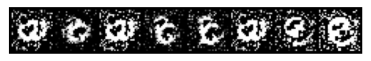

In [43]:
model = GAN(*dm.dims)
model_name = "GAN"
trainer = pl.Trainer(
    default_root_dir=os.path.join(CHECKPOINT_PATH, "gan"),
    accelerator="auto",
    devices=1,
    max_epochs=200,
    callbacks=[
        ModelCheckpoint(save_weights_only=True, mode="min", monitor="d_loss"),
        LearningRateMonitor("epoch"),
    ],
)

trainer.fit(model, dm)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


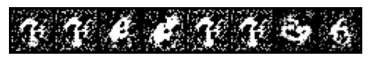

In [20]:
model = GAN(*dm.dims)
ckpt = torch.load(
    os.path.join(
        CHECKPOINT_PATH,
        "gan/lightning_logs/version_10/checkpoints/epoch=125-step=54180.ckpt",
    )
)
model.load_state_dict(ckpt["state_dict"])
model.eval()

z = torch.randn(8, model.hparams.latent_dim)
z = z.type_as(next(model.parameters()))
sample_imgs = model(z)
grid = torchvision.utils.make_grid(sample_imgs)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.show()

# VAE

以下代码实现了一个自定义的变分自编码器VAE，其中包括Encoder，Decoder，与VAE类。

In [10]:
# Encoder definition
class Encoder(nn.Module):
    def __init__(
        self, num_input_channels, base_channel_size, latent_dim, act_fn=nn.GELU
    ):
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(
                num_input_channels, c_hid, kernel_size=3, padding=1, stride=2
            ),  # 28x28 => 14x14
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(
                c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2
            ),  # 14x14 => 7x7
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Flatten(),  # Image grid to single feature vector
            nn.Linear(2 * 7 * 7 * c_hid, latent_dim),
        )

    def forward(self, x):
        return self.net(x)


# Decoder definition
class Decoder(nn.Module):
    def __init__(
        self, num_input_channels, base_channel_size, latent_dim, act_fn=nn.GELU
    ):
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(nn.Linear(latent_dim, 2 * c_hid * 7 * 7), act_fn())
        self.net = nn.Sequential(
            nn.ConvTranspose2d(
                2 * c_hid,
                2 * c_hid,
                kernel_size=3,
                output_padding=1,
                padding=1,
                stride=2,
            ),  # 7x7 => 14x14
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(
                2 * c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2
            ),  # 14x14 => 28x28
            act_fn(),
            nn.Conv2d(c_hid, num_input_channels, kernel_size=3, padding=1),
            nn.Tanh(),
        )
        self.base_channel_size = base_channel_size

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(
            x.shape[0], 2 * self.base_channel_size, 7, 7
        )  # Ensure correct shape
        x = self.net(x)
        return x


# VAE definition
class VAE(pl.LightningModule):
    def __init__(
        self, num_input_channels, width, height, base_channel_size, latent_dim
    ):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = Encoder(num_input_channels, base_channel_size, latent_dim)
        self.decoder = Decoder(num_input_channels, base_channel_size, latent_dim)
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        x, _ = batch  # We do not need the labels
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.2, patience=20, min_lr=5e-5
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_loss",
        }

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("test_loss", loss)


class GenerateCallback(pl.Callback):

    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs  # Images to reconstruct during training
        # Only save those images every N epochs (otherwise tensorboard gets quite large)
        self.every_n_epochs = every_n_epochs

    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            input_imgs = self.input_imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()
            # Plot and add to tensorboard
            imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0, 1)
            grid = torchvision.utils.make_grid(
                imgs, nrow=2, normalize=True, range=(-1, 1)
            )
            trainer.logger.experiment.add_image(
                "Reconstructions", grid, global_step=trainer.global_step
            )

# util funcs
vae_train_set = MNIST(
    DATASET_PATH, train=True, transform=transforms.ToTensor(), download=False
)

def get_train_images(num):
    return torch.stack([vae_train_set[i][0] for i in range(num)], dim=0)

def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(model.device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0, 1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1, 1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7, 4.5))
    plt.title("Reconstructed from %i latents" % (model.hparams.latent_dim))
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

以下代码实现了VAE的训练，包括定义Trainer，对256latent dim的VAE模型进行训练。

In [7]:
dm = MNISTDataModule()
model_dict = {}
model = VAE(
    num_input_channels=1, width=28, height=28, base_channel_size=32, latent_dim=256
)

trainer = pl.Trainer(
    default_root_dir=os.path.join(CHECKPOINT_PATH, "vae"),
    accelerator="auto",
    devices=1,
    max_epochs=200,
    callbacks=[
        ModelCheckpoint(save_weights_only=True),
        GenerateCallback(get_train_images(8), every_n_epochs=10),
        LearningRateMonitor("epoch"),
    ],
)

model_, result_ = model, trainer.fit(model, dm)
model_dict[256] = {"model": model_, "result": result_}

/data22/DISCOVER_summer2023/chenjt2305/.miniconda/envs/dl2023/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data22/DISCOVER_summer2023/chenjt2305/.miniconda/en ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/data22/DISCOVER_summer2023/chenjt2305/.miniconda/envs/dl2023/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data22/DISCOVER_summer2023/chenjt2305/.miniconda/en ...
  rank_zero_warn(
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/data22/DISCOVER_summer2023/chenjt2305/.miniconda/envs/dl2023/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, a

此处代码加载刚才训练得到的VAE模型，并展示MNIST数据集上的生成结果。

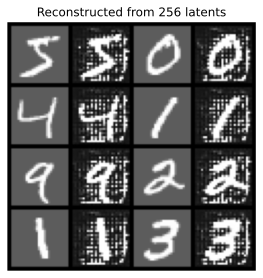

In [17]:
vae_model = VAE(num_input_channels=1, width=28, height=28, base_channel_size=32, latent_dim=256)
ckpt = torch.load(
    os.path.join(CHECKPOINT_PATH, "vae/lightning_logs/version_15/checkpoints/epoch=181-step=39130.ckpt")
)
vae_model.load_state_dict(ckpt["state_dict"])

input_imgs = get_train_images(8)
visualize_reconstructions(vae_model, input_imgs)

# Diffusion

以下代码实现了一个高度自定义化的Diffusion模型。

In [12]:

class SelfAttention(nn.Module):
    def __init__(self, h_size):
        super(SelfAttention, self).__init__()
        self.h_size = h_size
        self.mha = nn.MultiheadAttention(h_size, 4, batch_first=True)
        self.ln = nn.LayerNorm([h_size])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([h_size]),
            nn.Linear(h_size, h_size),
            nn.GELU(),
            nn.Linear(h_size, h_size),
        )

    def forward(self, x):
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value


class SAWrapper(nn.Module):
    def __init__(self, h_size, num_s):
        super(SAWrapper, self).__init__()
        self.sa = nn.Sequential(*[SelfAttention(h_size) for _ in range(1)])
        self.num_s = num_s
        self.h_size = h_size

    def forward(self, x):
        x = x.view(-1, self.h_size, self.num_s * self.num_s).swapaxes(1, 2)
        x = self.sa(x)
        x = x.swapaxes(2, 1).view(-1, self.h_size, self.num_s, self.num_s)
        return x


# U-Net code adapted from: https://github.com/milesial/Pytorch-UNet


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, in_channels, residual=True)
            self.conv2 = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        x = self.conv2(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class DiffusionModel(pl.LightningModule):
    def __init__(self, in_size, t_range, img_depth):
        super().__init__()
        self.beta_small = 1e-4
        self.beta_large = 0.02
        self.t_range = t_range
        self.in_size = in_size

        bilinear = True
        self.inc = DoubleConv(img_depth, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down3 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64, bilinear)
        self.outc = OutConv(64, img_depth)
        self.sa1 = SAWrapper(256, 8)
        self.sa2 = SAWrapper(256, 4)
        self.sa3 = SAWrapper(128, 8)

    def pos_encoding(self, t, channels, embed_size):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc.view(-1, channels, 1, 1).repeat(1, 1, embed_size, embed_size)

    def forward(self, x, t):
        """
        Model is U-Net with added positional encodings and self-attention layers.
        """
        x1 = self.inc(x)
        x2 = self.down1(x1) + self.pos_encoding(t, 128, 16)
        x3 = self.down2(x2) + self.pos_encoding(t, 256, 8)
        x3 = self.sa1(x3)
        x4 = self.down3(x3) + self.pos_encoding(t, 256, 4)
        x4 = self.sa2(x4)
        x = self.up1(x4, x3) + self.pos_encoding(t, 128, 8)
        x = self.sa3(x)
        x = self.up2(x, x2) + self.pos_encoding(t, 64, 16)
        x = self.up3(x, x1) + self.pos_encoding(t, 64, 32)
        output = self.outc(x)
        return output

    def beta(self, t):
        return self.beta_small + (t / self.t_range) * (
            self.beta_large - self.beta_small
        )

    def alpha(self, t):
        return 1 - self.beta(t)

    def alpha_bar(self, t):
        return math.prod([self.alpha(j) for j in range(t)])

    def get_loss(self, batch, batch_idx):
        """
        Corresponds to Algorithm 1 from (Ho et al., 2020).
        """
        ts = torch.randint(0, self.t_range, [batch.shape[0]], device=self.device)
        noise_imgs = []
        epsilons = torch.randn(batch.shape, device=self.device)
        for i in range(len(ts)):
            a_hat = self.alpha_bar(ts[i])
            noise_imgs.append(
                (math.sqrt(a_hat) * batch[i]) + (math.sqrt(1 - a_hat) * epsilons[i])
            )
        noise_imgs = torch.stack(noise_imgs, dim=0)
        e_hat = self.forward(noise_imgs, ts.unsqueeze(-1).type(torch.float))
        loss = nn.functional.mse_loss(
            e_hat.reshape(-1, self.in_size), epsilons.reshape(-1, self.in_size)
        )
        return loss

    def denoise_sample(self, x, t):
        """
        Corresponds to the inner loop of Algorithm 2 from (Ho et al., 2020).
        """
        with torch.no_grad():
            if t > 1:
                z = torch.randn(x.shape, device=x.device)
            else:
                z = 0
            e_hat = self.forward(x, t.view(1, 1).repeat(x.shape[0], 1))
            pre_scale = 1 / math.sqrt(self.alpha(t))
            e_scale = (1 - self.alpha(t)) / math.sqrt(1 - self.alpha_bar(t))
            post_sigma = math.sqrt(self.beta(t)) * z
            x = pre_scale * (x - e_scale * e_hat) + post_sigma
            return x

    def training_step(self, batch, batch_idx):
        loss = self.get_loss(batch, batch_idx)
        self.log("train/loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.get_loss(batch, batch_idx)
        self.log("val/loss", loss)
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        return optimizer

以下代码定义了Diffusion模型的训练方法。由于训练在另一个文件中进行，仅在ipynb中进行整合，所以该cell无output，但保留tensorboard log。

In [ ]:
# Create datasets and data loaders
train_dataset = DiffSet(True)
val_dataset = DiffSet(False)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=True
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)


model = DiffusionModel(
    train_dataset.size * train_dataset.size, 1000, train_dataset.depth
)

trainer = pl.Trainer(
    default_root_dir=os.path.join(CHECKPOINT_PATH, "diffusion"),
    max_epochs=200,
    log_every_n_steps=10,
    accelerator="auto",
    devices=[1],
)

trainer.fit(model, train_loader, val_loader)

以下代码展示了加载上一步训练得到的模型，从随机噪声中denoising出MNIST数据集中照片的过程。

In [15]:
# Create datasets and data loaders
train_dataset = DiffSet(True)
val_dataset = DiffSet(False)
model = DiffusionModel(
    train_dataset.size * train_dataset.size, 1000, train_dataset.depth
)
ckpt = torch.load(
os.path.join(CHECKPOINT_PATH, "diffusion/lightning_logs/MNIST/version_1/checkpoints/epoch=54-step=12925.ckpt")
)
model.load_state_dict(ckpt["state_dict"])

<All keys matched successfully>

以下代码展示diffusion模型训练的可视化结果，其中在Jupyter line中展示了渲染的最终图，在当前目录下保存了一个gif，展示denoising的过程。

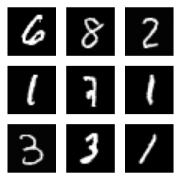

<Figure size 640x480 with 0 Axes>

In [18]:
gif_shape = [3, 3]
sample_batch_size = gif_shape[0] * gif_shape[1]
n_hold_final = 1

# Generate samples from denoising process
gen_samples = []
x = torch.randn(
    (sample_batch_size, train_dataset.depth, train_dataset.size, train_dataset.size)
)
sample_steps = torch.arange(model.t_range - 1, 0, -1)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
x = x.to(device)
sample_steps = sample_steps.to(device)

for t in sample_steps:
    x = model.denoise_sample(x, t)
    if t % 50 == 0:
        gen_samples.append(x)
for _ in range(n_hold_final):
    gen_samples.append(x)
gen_samples = torch.stack(gen_samples, dim=0).moveaxis(2, 4).squeeze(-1)
gen_samples = (gen_samples.clamp(-1, 1) + 1) / 2

# Process samples and save as gif
gen_samples = (gen_samples * 255).type(torch.uint8)
gen_samples = gen_samples.reshape(
    -1,
    gif_shape[0],
    gif_shape[1],
    train_dataset.size,
    train_dataset.size,
    train_dataset.depth,
)

final_res = gen_samples[-1, :, :, :, :, :].cpu().numpy()


gen_samples.squeeze_(-1)

def stack_samples(gen_samples, stack_dim):
    gen_samples = list(torch.split(gen_samples, 1, dim=1))
    for i in range(len(gen_samples)):
        gen_samples[i] = gen_samples[i].squeeze(1)
    return torch.cat(gen_samples, dim=stack_dim)


gen_samples = stack_samples(gen_samples, 2)
gen_samples = stack_samples(gen_samples, 2)

imageio.mimsave(
    f"./diffusion_pred.gif",
    list(gen_samples.cpu().numpy()),
    fps=5,
)

# plot it
fig, axs = plt.subplots(gif_shape[0], gif_shape[1], figsize=(3, 3))
for i in range(gif_shape[0]):
    for j in range(gif_shape[1]):
        axs[i, j].imshow(final_res[i, j, :, :, 0], cmap="gray")
        axs[i, j].axis("off")
plt.show()

# 结果对比与实验结论

## 生成模型对比
1. NF（Normalizing Flow）：

    基于可逆变换的生成模型，通过变换使得简单分布（如高斯分布）与复杂分布（如图像数据）之间可相互转换。

2. GAN（Generative Adversarial Network）：

    由生成器和判别器组成，通过对抗训练生成逼真的数据。

3. VAE（Variational Autoencoder）：

    通过编码器将输入映射到潜在空间，并从潜在空间中生成新的数据。

4. Diffusion Model：

    通过逐步去噪过程从噪声分布生成数据。


## 定性结果展示

实验主要展示了各生成模型在MNIST数据集上生成的图像。由于不同模型的训练损失不具备泛化参考意义，实验结果主要以定性结果（Qualitative Results）为主。

### Normalizing Flows (NF)

![NF](./_static/nf.png)

1. 优点：生成图像质量高，细节丰富。
2. 缺点：训练过程较为复杂，对模型的初始化和超参数敏感。

### Generative Adversarial Networks (GAN)

![GAN](./_static/gan.png)

1. 优点：训练速度快。
2. 缺点：训练不稳定，容易发生模式崩溃（mode collapse）。


### Variational Autoencoders (VAE)

![VAE](./_static/vae.png)

1. 优点：生成过程稳定，训练较为简单。
2. 缺点：生成图像质量相对较差，容易出现模糊。


### Diffusion Models

![Diffusion](./_static/diffusion.png)

1. 优点：生成图像质量高，细节处理良好。
2. 缺点：生成过程较慢，需要较多计算资源。

### 生成质量的评估

在视觉效果上，Diffusion和NF模型生成的图像质量较高，而VAE生成的图像相对较模糊，但其训练稳定性和简单性使其在一些应用场景下具有优势。GAN则容易训练时发生模式崩溃。

### 计算资源要求

1. NF和Diffusion：计算资源需求较高，训练时间较长。
2. GAN：计算资源需求适中，但训练过程可能需要反复调整超参数以确保稳定性。
3. VAE：计算资源需求较低，训练时间较短。


## 结论

通过对四种生成模型在MNIST数据集上的对比实验，可以得出以下结论：

### 生成质量：
1. Diffusion和NF模型在生成图像质量上表现最佳，适用于对生成图像质量要求较高的场景。
2. GAN模型需解决训练不稳定的问题。
3. VAE模型生成图像质量较差，但适用于对训练稳定性和计算资源要求较低的场景。

### 训练稳定性：
1. VAE和Diffusion模型训练过程较为稳定。
2. GAN模型训练过程不稳定，需通过经验调整超参数。
3. NF模型对初始化和超参数较为敏感，需要较多调试。

### 计算资源需求：
1. Diffusion和NF模型计算资源需求较高，适用于有充足计算资源的环境。(较高的显存)
2. VAE和GAN模型计算资源需求较低，适用于资源受限的环境。


综合考虑生成质量、训练稳定性和计算资源需求，可以根据具体应用场景选择合适的生成模型。在对生成图像质量要求较高且计算资源充足的情况下，建议选择Diffusion或NF模型；在计算资源有限或对训练稳定性要求较高的情况下，建议选择VAE模型；在需要生成逼真图像且能够进行超参数调试的情况下，GAN模型是一个不错的选择。
